## Dự đoán giá lúa với LSTM và GRU

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import warnings
warnings.filterwarnings('ignore')

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pi
import plotly.express as px

from scipy import stats
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

### EDA

In [2]:
df = pd.read_csv('./gasoline_prices.csv',  parse_dates=['date'], index_col='date')

In [3]:
def timeseries (x_axis, y_axis, x_label):
    plt.figure(figsize = (10, 6))
    plt.plot(x_axis, y_axis, color ='black')
    plt.xlabel(x_label, {'fontsize': 12}) 
    plt.ylabel('RON 95-III', {'fontsize': 12})

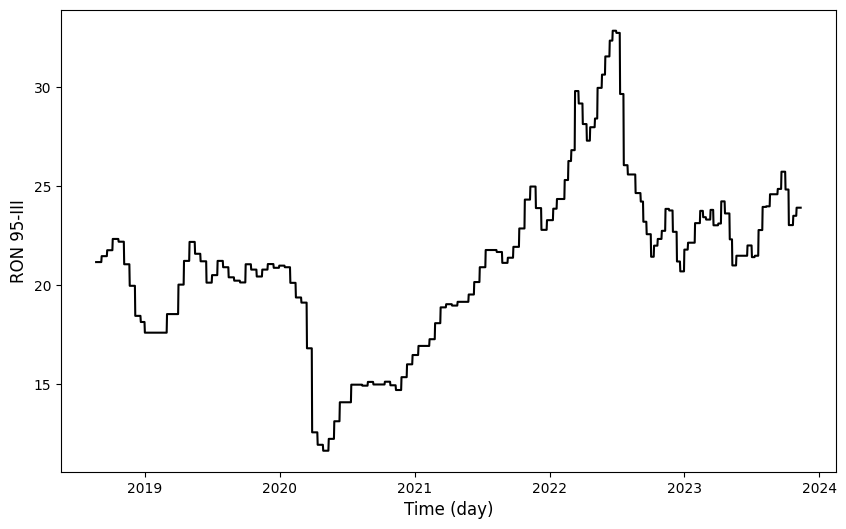

In [4]:
dataset = df.copy()
timeseries(df.index, dataset['RON 95-III'], 'Time (day)')

In [5]:
df.index

DatetimeIndex(['2018-08-22', '2018-08-23', '2018-08-24', '2018-08-25',
               '2018-08-26', '2018-08-27', '2018-08-28', '2018-08-29',
               '2018-08-30', '2018-08-31',
               ...
               '2023-11-03', '2023-11-04', '2023-11-05', '2023-11-06',
               '2023-11-07', '2023-11-08', '2023-11-09', '2023-11-10',
               '2023-11-11', '2023-11-12'],
              dtype='datetime64[ns]', name='date', length=1909, freq=None)

In [6]:
# Check for missing values
df = df.loc[:,['RON 95-III']]
df.head()

,RON 95-III
date,
2018-08-22,21.17
2018-08-23,21.17
2018-08-24,21.17
2018-08-25,21.17
2018-08-26,21.17


In [7]:
# print('Total num of missing values:') 
# print(df.price.isna().sum())
# df.price.isna()

In [8]:
df[df.index.duplicated()]

,RON 95-III
date,


In [9]:
df.dropna(subset=['RON 95-III'], inplace=True)

In [10]:
df = df.groupby('date', as_index=True).mean()
df.head()

,RON 95-III
date,
2018-08-22,21.17
2018-08-23,21.17
2018-08-24,21.17
2018-08-25,21.17
2018-08-26,21.17


In [11]:
df.shape

(1909, 1)

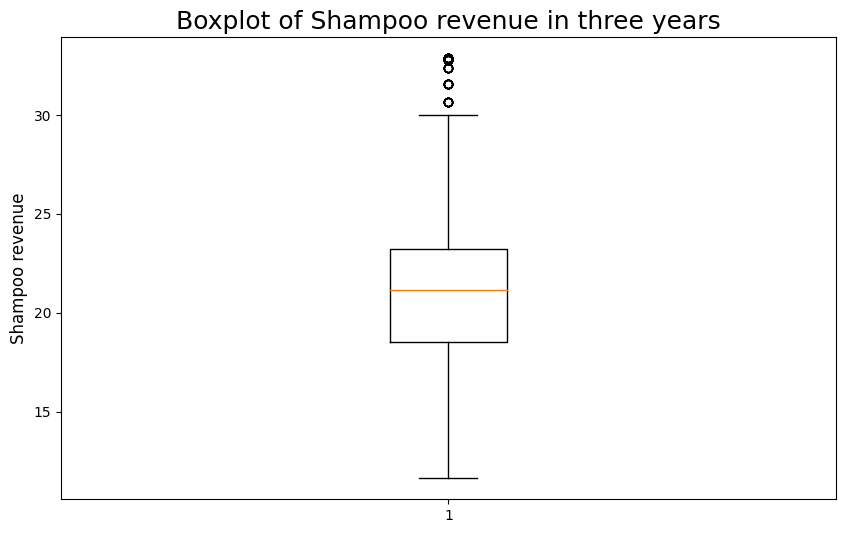

In [12]:
plt.figure(figsize=(10, 6))
plt.boxplot(df)
plt.ylabel("Shampoo revenue", fontsize=12)
plt.title("Boxplot of Shampoo revenue in three years", fontsize=18)
plt.show()

In [13]:
def detect_outliers(series):
  """
    series: 1-D numpy array input
  """
  Q1 = np.quantile(series, 0.25)
  Q3 = np.quantile(series, 0.75)
  IQR = Q3-Q1
  lower_bound = Q1-1.5*IQR
  upper_bound = Q3+1.5*IQR
  lower_compare = series <= lower_bound
  upper_compare = series >= upper_bound
  outlier_idxs = np.where(lower_compare | upper_compare)[0]
  return outlier_idxs

outlier_idxs=detect_outliers(df)
print("Outlier indices: ", outlier_idxs)
print("Outlier values: ", df.iloc[outlier_idxs])

Outlier indices:  [1370 1371 1372 1373 1374 1375 1376 1377 1378 1379 1380 1381 1382 1383
 1384 1385 1386 1387 1388 1389 1390 1391 1392 1393 1394 1395 1396 1397
 1398 1399 1400 1401 1402 1403 1404 1405 1406 1407 1408 1409 1410 1411
 1412 1413 1414 1415 1416 1417 1418]
Outlier values:              RON 95-III
date                  
2022-05-23       30.65
2022-05-24       30.65
2022-05-25       30.65
2022-05-26       30.65
2022-05-27       30.65
2022-05-28       30.65
2022-05-29       30.65
2022-05-30       30.65
2022-05-31       30.65
2022-06-01       31.57
2022-06-02       31.57
2022-06-03       31.57
2022-06-04       31.57
2022-06-05       31.57
2022-06-06       31.57
2022-06-07       31.57
2022-06-08       31.57
2022-06-09       31.57
2022-06-10       31.57
2022-06-11       31.57
2022-06-12       31.57
2022-06-13       32.37
2022-06-14       32.37
2022-06-15       32.37
2022-06-16       32.37
2022-06-17       32.37
2022-06-18       32.37
2022-06-19       32.37
2022-06-20       32.37
20

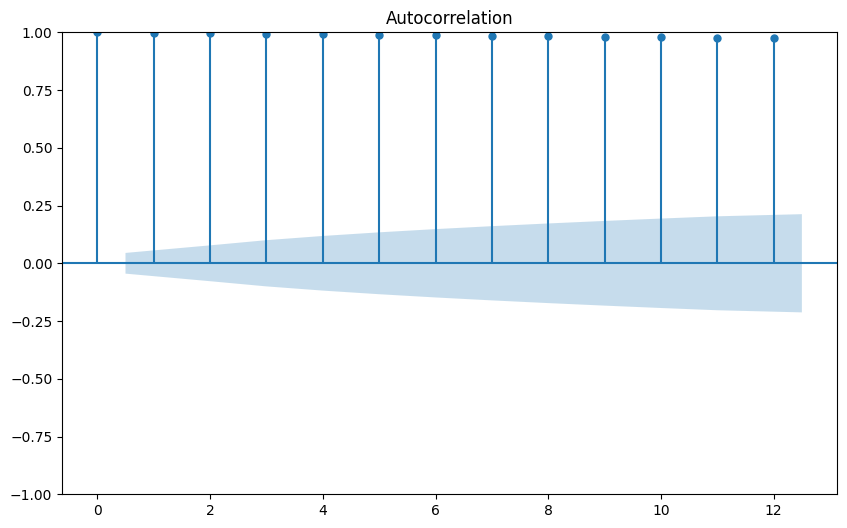

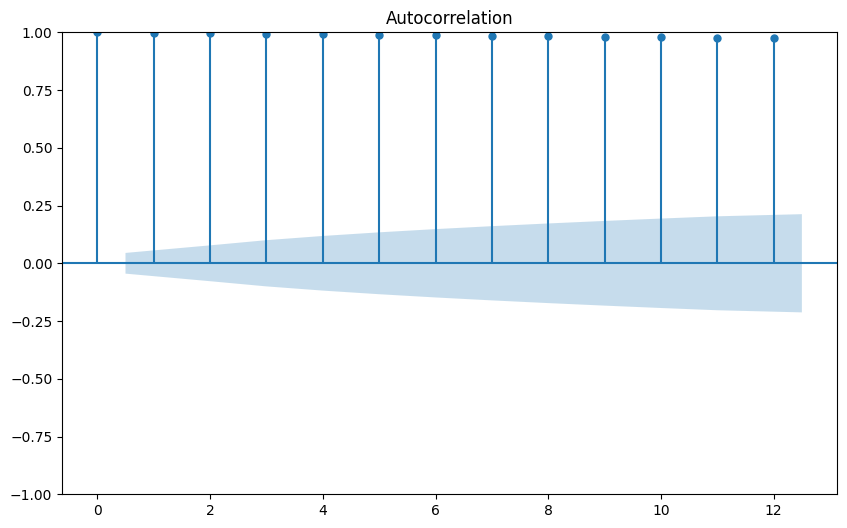

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rc("figure", figsize=(10, 6))
plot_acf(df["RON 95-III"], lags = 12)

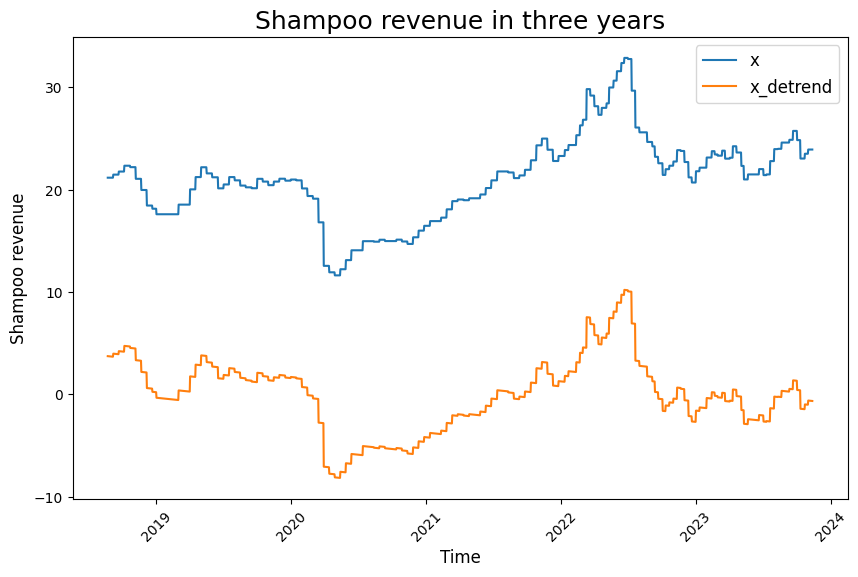

In [15]:
import numpy as np
from scipy import signal

x_detrend = signal.detrend(df["RON 95-III"])
df_detrend = pd.DataFrame({"Sales_Detrend": x_detrend}, index=df.index)

plt.figure(figsize=(10, 6))
plt.plot(df["RON 95-III"], label="x")
plt.plot(df_detrend, label="x_detrend")
plt.xticks(rotation=45)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Shampoo revenue", fontsize=12)
plt.legend(fontsize=12)
plt.title("Shampoo revenue in three years", fontsize=18)
plt.show()

### Tạo dữ liệu huấn luyện

In [16]:
dataset = df.copy()
dataset = dataset.resample('D').ffill()
# Split train data and test data
train_size = int(len(dataset)*0.8)

# train_data = df.WC.loc[:train_size] -----> it gives a series
# Do not forget use iloc to select a number of rows
train_data = dataset.iloc[:train_size]
test_data = dataset.iloc[train_size:]

In [17]:
print(train_data.shape)
print(test_data.shape)

(1527, 1)
(382, 1)


In [18]:
# Scale data
# The input to scaler.fit -> array-like, sparse matrix, dataframe of shape (n_samples, n_features)
scaler = MinMaxScaler().fit(train_data)

train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

In [19]:
print(train_scaled.shape)
print(test_scaled.shape)

(1527, 1)
(382, 1)


In [20]:
# Create input dataset
# Th input shape should be [samples, time steps, features]
def create_dataset (X, look_back = 12):
    Xs, ys = [], []
    
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])

    return np.array(Xs), np.array(ys)
# Gia 12 thang
look_back = 30
X_train, y_train = create_dataset(train_scaled, look_back)
X_test, y_test = create_dataset(test_scaled, look_back)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (1497, 30, 1)
y_train.shape:  (1497, 1)
X_test.shape:  (352, 30, 1)
y_test.shape:  (352, 1)


### Định nghĩa mô hình

In [21]:
# Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer 
    model.add(GRU (units = units, 
                 input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2)) 
      # Hidden layer
#     model.add(GRU (units = units,  return_sequences=True))                
#     model.add(Dropout(0.2))
    # Hidden layer
#     model.add(GRU(units = units))                        
#     model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
   
    return model
model_gru = create_gru(64)

In [22]:
def create_lstm(units):
    model = Sequential()
    # Input layer
    model.add(LSTM(units = units, 
                            input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2)) 
    # Hidden layer
#     model.add(LSTM(units = units, return_sequences=True))
#     model.add(Dropout(0.2)) 
#     model.add(LSTM(units = units))
#     model.add(Dropout(0.2))
    model.add(Dense(1))
    #Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
   
model_lstm = create_lstm(64)

In [23]:
def fit_model(model):
    history = model.fit(X_train, y_train, epochs = 200, batch_size = 64, shuffle = False)
    return history

In [24]:
history_gru = fit_model(model_gru)

Epoch 1/200
24/24 [==============================] - 4s 17ms/step - loss: 0.0388
Epoch 2/200
24/24 [==============================] - 0s 17ms/step - loss: 0.0218
Epoch 3/200
24/24 [==============================] - 0s 17ms/step - loss: 0.0083
Epoch 4/200
24/24 [==============================] - 0s 17ms/step - loss: 0.0036
Epoch 5/200
24/24 [==============================] - 0s 18ms/step - loss: 0.0028
Epoch 6/200
24/24 [==============================] - 0s 18ms/step - loss: 0.0023
Epoch 7/200
24/24 [==============================] - 0s 17ms/step - loss: 0.0022
Epoch 8/200
24/24 [==============================] - 0s 17ms/step - loss: 0.0021
Epoch 9/200
24/24 [==============================] - 0s 17ms/step - loss: 0.0020
Epoch 10/200
24/24 [==============================] - 0s 16ms/step - loss: 0.0021
Epoch 11/200
24/24 [==============================] - 0s 18ms/step - loss: 0.0019
Epoch 12/200
24/24 [==============================] - 0s 18ms/step - loss: 0.0019
Epoch 13/200
24/24 [=====

Epoch 100/200
24/24 [==============================] - 0s 18ms/step - loss: 9.3264e-04
Epoch 101/200
24/24 [==============================] - 0s 17ms/step - loss: 8.3137e-04
Epoch 102/200
24/24 [==============================] - 0s 18ms/step - loss: 8.7508e-04
Epoch 103/200
24/24 [==============================] - 0s 18ms/step - loss: 8.1665e-04
Epoch 104/200
24/24 [==============================] - 0s 18ms/step - loss: 8.6160e-04
Epoch 105/200
24/24 [==============================] - 0s 18ms/step - loss: 8.6332e-04
Epoch 106/200
24/24 [==============================] - 0s 18ms/step - loss: 9.2419e-04
Epoch 107/200
24/24 [==============================] - 0s 18ms/step - loss: 8.3173e-04
Epoch 108/200
24/24 [==============================] - 0s 18ms/step - loss: 8.0983e-04
Epoch 109/200
24/24 [==============================] - 0s 17ms/step - loss: 9.2183e-04
Epoch 110/200
24/24 [==============================] - 0s 17ms/step - loss: 9.1729e-04
Epoch 111/200
24/24 [======================

24/24 [==============================] - 0s 17ms/step - loss: 9.3031e-04
Epoch 195/200
24/24 [==============================] - 0s 17ms/step - loss: 8.3627e-04
Epoch 196/200
24/24 [==============================] - 0s 17ms/step - loss: 7.0718e-04
Epoch 197/200
24/24 [==============================] - 0s 17ms/step - loss: 7.1794e-04
Epoch 198/200
24/24 [==============================] - 0s 17ms/step - loss: 6.6817e-04
Epoch 199/200
24/24 [==============================] - 0s 17ms/step - loss: 6.1683e-04
Epoch 200/200
24/24 [==============================] - 0s 17ms/step - loss: 5.3972e-04


In [25]:
def fit_model_LSTM(model):
    history = model.fit(X_train, y_train, epochs = 200, batch_size = 64, shuffle = False)
    return history

In [26]:
history_lstm = fit_model_LSTM(model_lstm)

Epoch 1/200
24/24 [==============================] - 4s 22ms/step - loss: 0.0282
Epoch 2/200
24/24 [==============================] - 1s 22ms/step - loss: 0.0046
Epoch 3/200
24/24 [==============================] - 1s 21ms/step - loss: 0.0034
Epoch 4/200
24/24 [==============================] - 1s 22ms/step - loss: 0.0035
Epoch 5/200
24/24 [==============================] - 1s 21ms/step - loss: 0.0031
Epoch 6/200
24/24 [==============================] - 1s 21ms/step - loss: 0.0037
Epoch 7/200
24/24 [==============================] - 1s 21ms/step - loss: 0.0037
Epoch 8/200
24/24 [==============================] - 1s 21ms/step - loss: 0.0034
Epoch 9/200
24/24 [==============================] - 1s 21ms/step - loss: 0.0032
Epoch 10/200
24/24 [==============================] - 1s 21ms/step - loss: 0.0026
Epoch 11/200
24/24 [==============================] - 1s 21ms/step - loss: 0.0023
Epoch 12/200
24/24 [==============================] - 1s 21ms/step - loss: 0.0020
Epoch 13/200
24/24 [=====

24/24 [==============================] - 0s 21ms/step - loss: 9.6571e-04
Epoch 101/200
24/24 [==============================] - 1s 21ms/step - loss: 9.2751e-04
Epoch 102/200
24/24 [==============================] - 1s 22ms/step - loss: 9.3779e-04
Epoch 103/200
24/24 [==============================] - 1s 22ms/step - loss: 9.5099e-04
Epoch 104/200
24/24 [==============================] - 0s 21ms/step - loss: 9.4227e-04
Epoch 105/200
24/24 [==============================] - 0s 21ms/step - loss: 9.8131e-04
Epoch 106/200
24/24 [==============================] - 0s 21ms/step - loss: 9.7615e-04
Epoch 107/200
24/24 [==============================] - 1s 22ms/step - loss: 0.0010
Epoch 108/200
24/24 [==============================] - 1s 21ms/step - loss: 9.2925e-04
Epoch 109/200
24/24 [==============================] - 1s 21ms/step - loss: 9.0806e-04
Epoch 110/200
24/24 [==============================] - 1s 21ms/step - loss: 9.4214e-04
Epoch 111/200
24/24 [==============================] - 0s 21m

24/24 [==============================] - 0s 20ms/step - loss: 5.6792e-04
Epoch 195/200
24/24 [==============================] - 1s 21ms/step - loss: 5.7456e-04
Epoch 196/200
24/24 [==============================] - 1s 21ms/step - loss: 5.3597e-04
Epoch 197/200
24/24 [==============================] - 1s 21ms/step - loss: 5.9080e-04
Epoch 198/200
24/24 [==============================] - 1s 21ms/step - loss: 5.7927e-04
Epoch 199/200
24/24 [==============================] - 1s 22ms/step - loss: 5.3888e-04
Epoch 200/200
24/24 [==============================] - 1s 21ms/step - loss: 5.2907e-04


In [27]:
# model_gru.save("model_gru.keras")
# model_lstm.save("model_lstm.keras")

In [28]:
batch_size = [16, 32, 64]
epochs = [20, 50, 10]
optimizers = ['adam', 'rmsprop']
param_grid = dict(batch_size=batch_size, epochs=epochs, optimizer=optimizers)
param_grid

{'batch_size': [16, 32, 64],
 'epochs': [20, 50, 10],
 'optimizer': ['adam', 'rmsprop']}

In [29]:
# from sklearn.model_selection import GridSearchCV
# from scikeras.wrappers import KerasClassifier

# model = KerasClassifier(build_fn=model_lstm, verbose=1)

# grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

# grid_result = grid.fit(X_train, y_train)

In [30]:
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

### Đánh giá kết quả

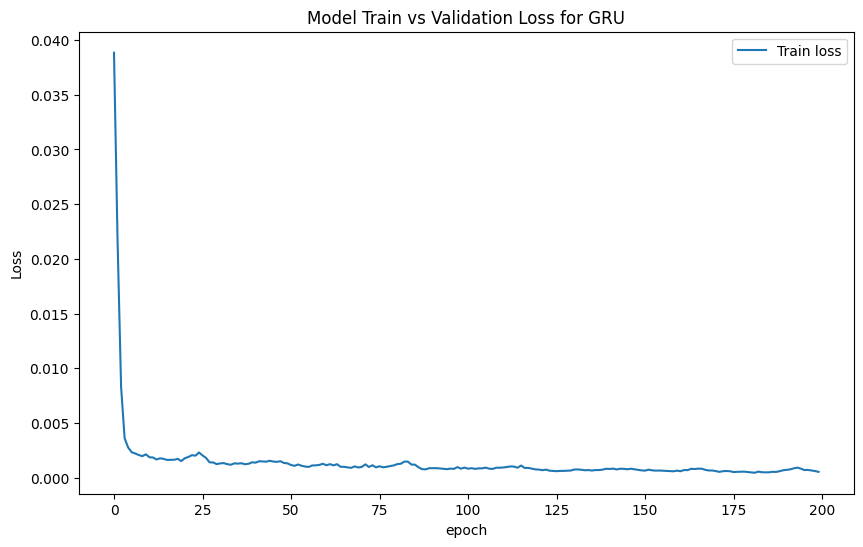

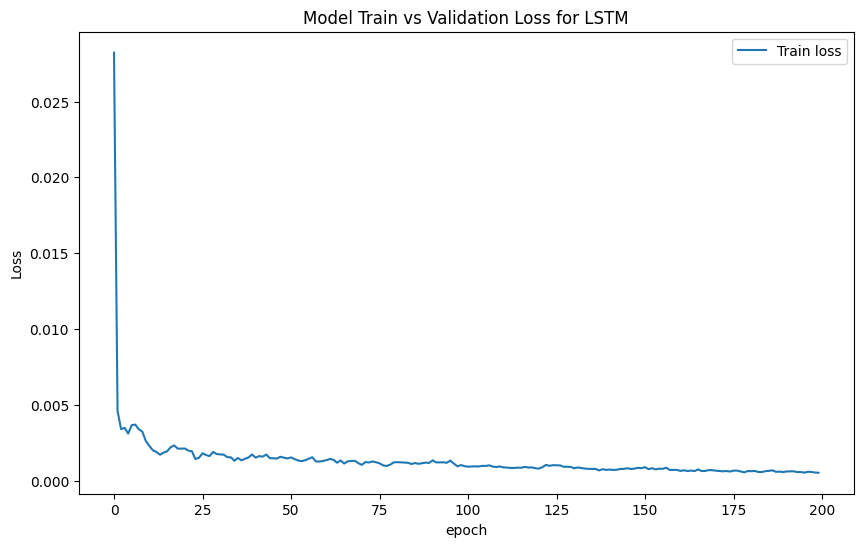

In [31]:
# Plot train loss and validation loss
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

plot_loss (history_gru, 'GRU')
plot_loss (history_lstm, 'LSTM')

In [32]:
# Transform data back to original data space
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction

def prediction_train(model):
    prediction = model.predict(X_train)
    prediction = scaler.inverse_transform(prediction)
    return prediction


prediction_gru = prediction(model_gru)
prediction_gru_train = prediction_train(model_gru)

prediction_lstm = prediction(model_lstm)
prediction_lstm_train = prediction_train(model_lstm)

47/47 [==============================] - 1s 7ms/step


TRAIN
GRU:
Mean Absolute Error: 0.2621
Root Mean Square Error: 0.3524
R2 Score: 0.9936

TRAIN
LSTM:
Mean Absolute Error: 0.2489
Root Mean Square Error: 0.3581
R2 Score: 0.9935

TEST
GRU:
Mean Absolute Error: 0.2200
Root Mean Square Error: 0.3061
R2 Score: 0.9411

TEST
LSTM:
Mean Absolute Error: 0.2616
Root Mean Square Error: 0.3567
R2 Score: 0.9236



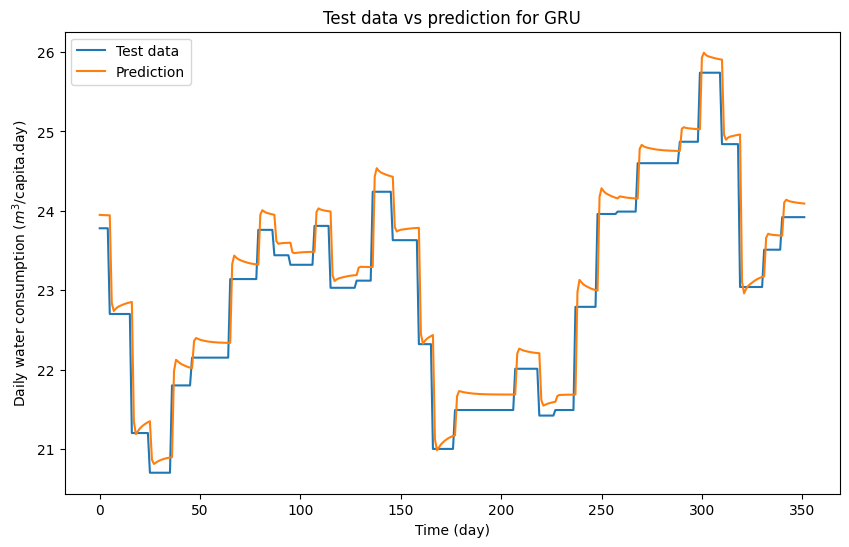

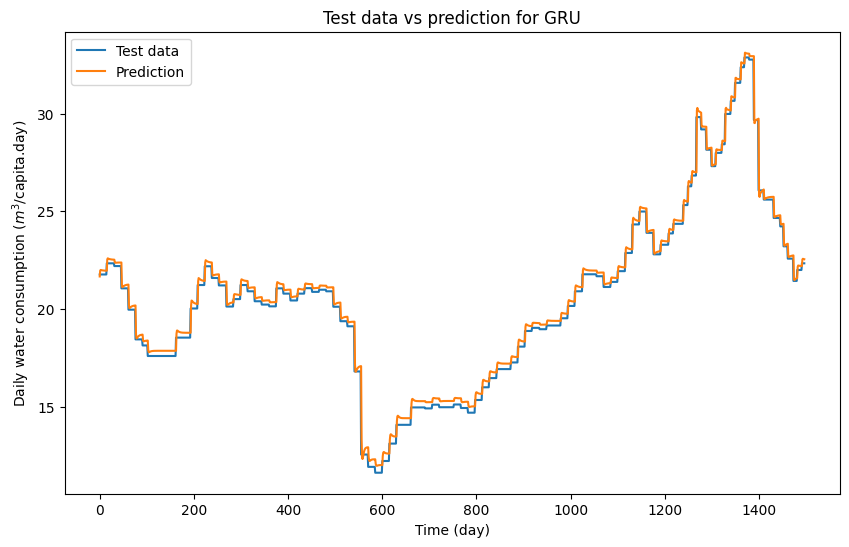

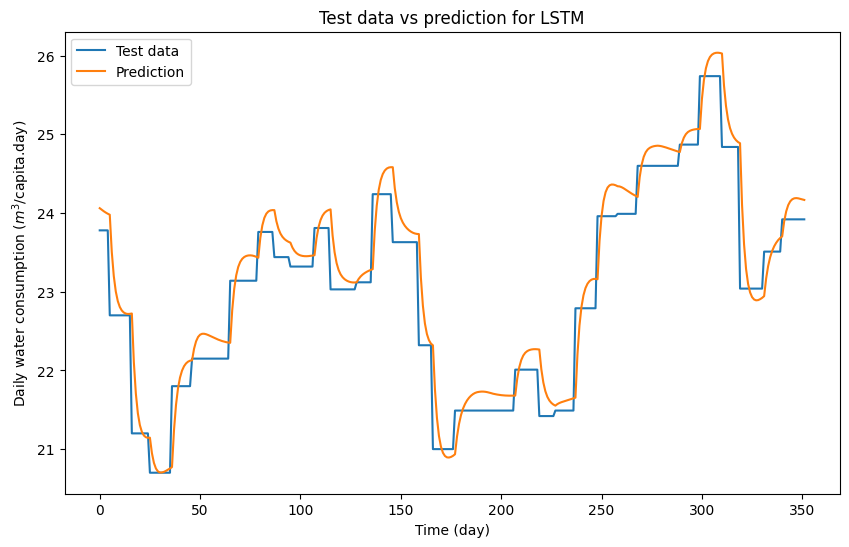

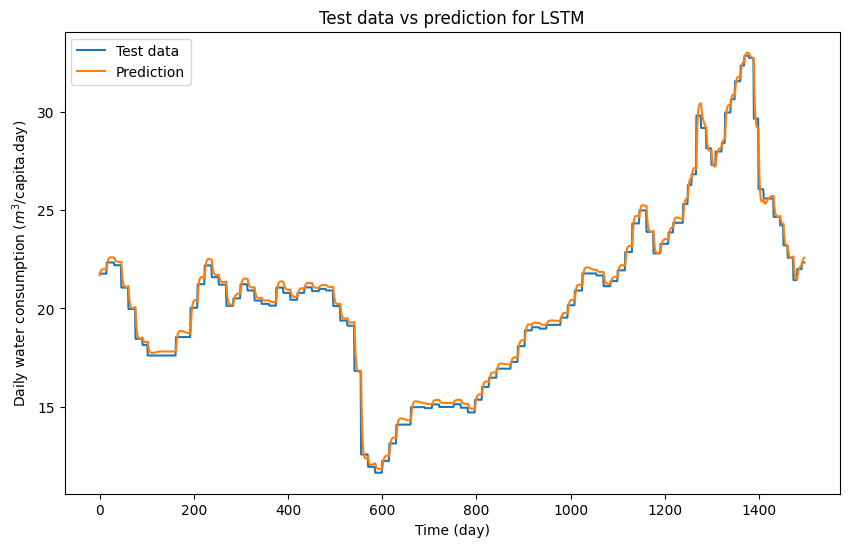

In [33]:
# Plot test data vs prediction
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='Test data')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('Daily water consumption ($m^3$/capita.day)')
       
plot_future(prediction_gru, 'GRU', y_test)
plot_future(prediction_gru_train, 'GRU', y_train)


plot_future(prediction_lstm, 'LSTM', y_test)
plot_future(prediction_lstm_train, 'LSTM', y_train)



from sklearn.metrics import r2_score 
# Calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name, data = 'TEST'):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print(data)
    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('R2 Score: {:.4f}'.format(r2_score(predictions, actual)))
    print('')

evaluate_prediction(prediction_gru_train, y_train, 'GRU', 'TRAIN')
evaluate_prediction(prediction_lstm_train, y_train, 'LSTM', 'TRAIN')

evaluate_prediction(prediction_gru, y_test, 'GRU')
evaluate_prediction(prediction_lstm, y_test, 'LSTM')

In [34]:
def predict(forecast_num, model,data,look_back):
  prediction_list = data[-look_back:]

  for _ in range(forecast_num):
      x = prediction_list[-look_back:]
      x = x.reshape((1, look_back, 1))
      out = model.predict(x)[0][0]
      prediction_list = np.append(prediction_list, out)
  prediction_list = prediction_list[look_back-1:]

  return prediction_list

def predict_dates(forecast_num, data):
    last_date = data.index[-1]
    prediction_dates = pd.date_range(last_date, periods=forecast_num+1).tolist()
    return prediction_dates

In [35]:
forecast_num = 30 #number of day to predict after the last date in data
forecast=predict(forecast_num, model=model_lstm,data=X_test[-1:],look_back=30)
forecast_date=predict_dates(forecast_num, df)

1/1 [==============================] - 0s 37ms/step


Text(0, 0.5, 'Daily water consumption ($m^3$/capita.day)')

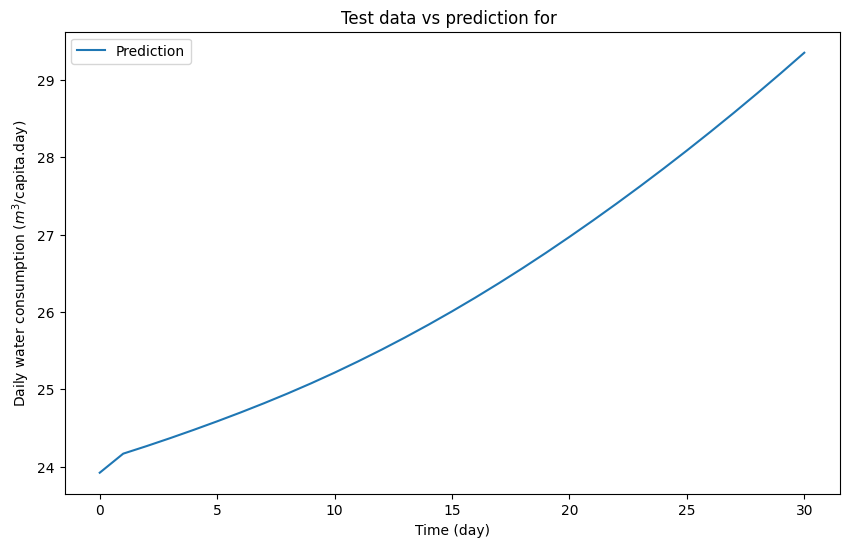

In [36]:
plt.figure(figsize=(10, 6))
    
f =  scaler.inverse_transform(forecast.reshape(-1, 1))
plt.plot(np.array(f),label='Prediction')

plt.title('Test data vs prediction for ')
plt.legend(loc='upper left')
plt.xlabel('Time (day)')
plt.ylabel('Daily water consumption ($m^3$/capita.day)')

In [37]:
forecast_num = 12 #number of day to predict after the last date in data
forecast=predict(forecast_num, model=model_gru,data=X_test[-1:],look_back=30)
forecast_date=predict_dates(forecast_num, df)

1/1 [==============================] - 0s 36ms/step


Text(0, 0.5, 'Daily water consumption ($m^3$/capita.day)')

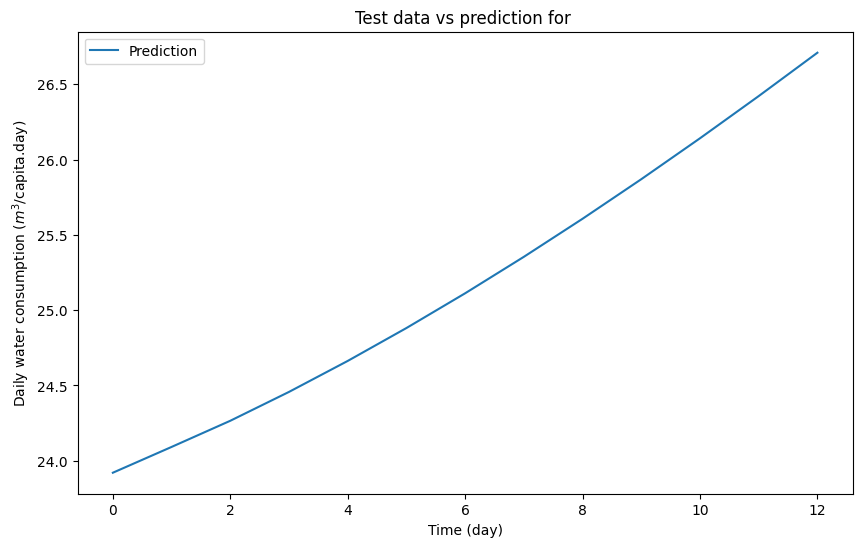

In [38]:
plt.figure(figsize=(10, 6))
    
f =  scaler.inverse_transform(forecast.reshape(-1, 1))
plt.plot(np.array(f),label='Prediction')

plt.title('Test data vs prediction for ')
plt.legend(loc='upper left')
plt.xlabel('Time (day)')
plt.ylabel('Daily water consumption ($m^3$/capita.day)')